In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt').read().splitlines()
print(words[:8])
print(len(words))

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']
32033


In [3]:
chars = sorted(set(''.join(words)))
s_to_i = {s:i+1 for i,s in enumerate(chars)}
s_to_i['.'] = 0
i_to_s = {i+1:s for i,s in enumerate(chars)}
i_to_s[0] = '.'

In [4]:
# i_to_s1 = {i+1:s for i,s in enumerate(chars)}
# i_to_s2 = {i:s for s,i in s_to_i.items()}

# print(i_to_s1)
# print(i_to_s2)
# i_to_s1 == i_to_s2

Build the dataset

In [5]:
block_size = 3 #context length: number of chars do we take to predict the next one
X, Y = [], []
for w in words:
    # print(w)
    context = [0]*block_size
    for c in w + '.':
        ix = s_to_i[c]
        X.append(context)
        Y.append(ix)
        # print(''.join(i_to_s[i] for i in context), '--->', i_to_s[ix])
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

# print(X,Y)

In [6]:
# block_size = 3 #context length: number of chars do we take to predict the next one
# X, Y = [], []
# for w in words[]:
#     context = [0]*block_size
#     for c in w + '.':
#         ix = s_to_i[c]
#         X.append(context)
#         Y.append(ix)
#         context = context[1:] + [ix]

# X = torch.tensor(X)
# Y = torch.tensor(Y)

In [45]:
def build_dataset(words):
    block_size = 3
    X, Y = [], []
    for w in words:
        context = [0]*block_size
        for c in w + '.':
            ix = s_to_i[c]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X,Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

X_train, Y_train = build_dataset(words[:n1])
X_val, Y_val = build_dataset(words[n1:n2])
X_test, Y_test = build_dataset(words[n2:])

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [7]:
C = torch.randn(27,2) #27 chars 2 dims
C

tensor([[-0.8818, -2.0713],
        [ 0.9453, -0.4679],
        [-0.6596,  1.1479],
        [ 0.1879, -0.1980],
        [ 1.4982, -1.8683],
        [ 1.3381, -0.7338],
        [-0.7930,  1.3530],
        [-0.0072, -0.1494],
        [ 0.1979,  0.5494],
        [ 1.0357,  0.6038],
        [-0.4901, -0.4389],
        [-1.4040,  0.6188],
        [ 0.0839, -0.8330],
        [ 2.0141,  0.4764],
        [-0.4173,  1.1939],
        [ 0.3262,  1.2247],
        [-0.8676,  0.7651],
        [ 1.0365, -0.9223],
        [ 1.0869, -0.1223],
        [ 0.5964, -0.5515],
        [ 1.4951,  0.0358],
        [-1.4128, -1.4912],
        [-0.5212, -0.9507],
        [ 0.8517,  1.9944],
        [ 0.3963,  1.5359],
        [-0.7537, -0.4332],
        [ 1.5078, -0.4803]])

In [8]:
C[5] #same as F.one_hot(torch.tensor(5), num_classes=27).float() @ C

tensor([ 1.3381, -0.7338])

In [9]:
# C[[[(0,0,5), (0,5,1), (0,0,0)]]] #embeddings for ..e, .ea, ... resp
C[torch.tensor([[ 0,  0,  5],
        [ 0,  5, 1],
        [ 0,  0, 0]])]

tensor([[[-0.8818, -2.0713],
         [-0.8818, -2.0713],
         [ 1.3381, -0.7338]],

        [[-0.8818, -2.0713],
         [ 1.3381, -0.7338],
         [ 0.9453, -0.4679]],

        [[-0.8818, -2.0713],
         [-0.8818, -2.0713],
         [-0.8818, -2.0713]]])

In [10]:
C[X] #shape is 32,3,2 (32 data points like ..., ..e, .em, emm, etc.; 3 is the context like ...; 2 is the dimension of each character)
#C[5] would be the embedding for e
#C[[]]

tensor([[[-0.8818, -2.0713],
         [-0.8818, -2.0713],
         [-0.8818, -2.0713]],

        [[-0.8818, -2.0713],
         [-0.8818, -2.0713],
         [ 1.3381, -0.7338]],

        [[-0.8818, -2.0713],
         [ 1.3381, -0.7338],
         [ 2.0141,  0.4764]],

        ...,

        [[ 1.5078, -0.4803],
         [ 1.5078, -0.4803],
         [-0.7537, -0.4332]],

        [[ 1.5078, -0.4803],
         [-0.7537, -0.4332],
         [ 1.5078, -0.4803]],

        [[-0.7537, -0.4332],
         [ 1.5078, -0.4803],
         [ 0.3963,  1.5359]]])

In [11]:
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [12]:
W1 = torch.rand((6,100)) #6 cuz 3 context * 2 dimensions
b1 = torch.rand(100)

In [ ]:
##we need to convert emb into something that we can multiply with W1 because we can't do 32,3,2 * 6,100
##emb[:, 0, :], emb[:, 1, :], emb[:, 2, :] #first char, second char, and third char
##torch.unbind(emb, 1) is the same as emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]
# concat_tensors = torch.unbind(emb, 1) 
# shapes = [concat_tensors[i].shape for i in range(3)]
# print(shapes)
# torch.cat(concat_tensors, 1) #along the first dimension and not the zeroth
#we can do the above or simply just do the following
# emb.view(32,6)

In [ ]:
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
h

In [15]:
W2 = torch.randn((100,27))
b2 = torch.randn(27)

In [16]:
logits = h @ W2 + b2
logits.shape

torch.Size([228146, 27])

In [17]:
counts = logits.exp()
prob = counts / counts.sum(1, keepdims=True)

In [ ]:
#prob[0,5] will tell us what the probability that the NN predicts e is since it is the 5th letter and the 1st target char
#prob[1,13] will tell us what the probability that the NN predicts e is since it is the 13th letter and the 2nd target char
loss = -prob[torch.arange(32), Y].log().mean()
loss

Cleaned code for the NN

In [19]:
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

The network architecture is as follows:<br>
6 neurons in the layer after embedding (3 chars * 2 dim)<br>
100 neurons in the 1st hidden layer<br>
27 neurons in the output layer after softmax


In [46]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2), generator=g)
W1 = torch.randn((6,100), generator=g)
b1 = torch.randn(100,  generator=g)
W2 = torch.randn(100,27,  generator=g)
b2 = torch.randn(27,  generator=g)
parameters = [C, W1, b1, W2, b2]

print(sum(p.nelement() for p in parameters))

3481


In [ ]:
# for p in parameters:
#     p.requires_grad = True

# for _ in range (1000):
#     # forward pass
#     emb = C[X] #(32,3,2)
#     h = torch.tanh(emb.view(-1,6) @ W1 + b1) #(32,100)
#     logits = h @ W2 + b2 #(32, 27)
#     # counts = logits.exp()
#     # prob = counts / counts.sum(1, keepdims=True)
#     # loss = -prob[torch.arange(32), Y].log().mean()
#     loss = F.cross_entropy(logits, Y) #this is the same as the three lines above
#     print(_,loss.item())

#     #backward pass
#     for p in parameters:
#         p.grad = None
#     loss.backward()

#     #update
#     for p in parameters:
#         p.data += -0.1 * p.grad

In [47]:
for p in parameters:
    p.requires_grad = True

In [36]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre
lrs

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
        0.0015, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
        0.0016, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
        0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0021, 0.0021, 0.0022, 

In [50]:
# lri = []
# lossi = []

for i in range (10000):

    #minibatch construct
    ix = torch.randint(0, X_train.shape[0], (32,))
    
    # forward pass
    emb = C[X_train[ix]] #(32,3,2)
    h = torch.tanh(emb.view(-1,6) @ W1 + b1) #(32,100)
    logits = h @ W2 + b2 #(32, 27)
    # counts = logits.exp()
    # prob = counts / counts.sum(1, keepdims=True)
    # loss = -prob[torch.arange(32), Y].log().mean()
    loss = F.cross_entropy(logits, Y_train[ix]) #this is the same as the three lines above
    # print(loss.item())

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    # lr = lrs[i]
    lr = 0.1
    for p in parameters:
        p.data -= lr* p.grad

    # #track stats
    # lri.append(lre[i])
    # lossi.append(loss.item())

print(loss.item())

#this is mini batch stochastic gradient descent

2.370163917541504


In [52]:
emb = C[X_train] #(32,3,2)
h = torch.tanh(emb.view(-1,6) @ W1 + b1) #(32,100)
logits = h @ W2 + b2 #(32, 27)
loss = F.cross_entropy(logits, Y_train) 
loss

tensor(2.4820, grad_fn=<NllLossBackward0>)

In [51]:
emb = C[X_val] #(32,3,2)
h = torch.tanh(emb.view(-1,6) @ W1 + b1) #(32,100)
logits = h @ W2 + b2 #(32, 27)
loss = F.cross_entropy(logits, Y_val) 
loss

tensor(2.4802, grad_fn=<NllLossBackward0>)

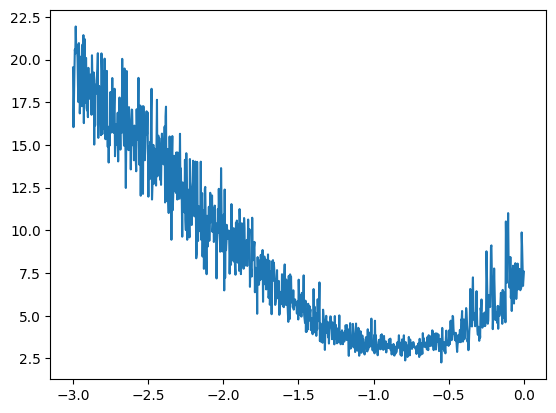

In [ ]:
plt.plot(lri, lossi) #we can see from the plot that at lre=-1.0 or lr=0.1 the loss is minimum 